In [179]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split

In [409]:
# Load the data
directory = os.getcwd()
file_path = os.path.join(directory, 'data.csv')
df = pd.read_csv(file_path, encoding='cp1251')

# Rename columns if necessary
# df.rename(columns={'old_column_name': 'new_column_name'}, inplace=True)

# Parse the date column and set it as the index
#df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
df.set_index('date', inplace=True)

# Assume the target variable to forecast is the first column
target_variable = df.columns[0]

df[target_variable] = df[target_variable]
# Create lag features
num_lags = 4

for i in range(1, num_lags + 1):
    df[f'lag_{i}'] = df[target_variable].shift(i)

# Split the data into training and test sets
train, test = train_test_split(df, test_size=0.2, shuffle=False)

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

y_train_mean = train[target_variable].mean()

for i in range(1, num_lags + 1):
    train[f'lag_{i}'].fillna(y_train_mean, inplace = True)


# Display the first few rows
display(train.head())

c:\Users\lysov\Documents\GitHub\CBR-DS-Tech-Task\venv\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


,CPI,lag_1,lag_2,lag_3,lag_4
date,,,,,
2016-01-01,109.77,105.658875,105.658875,105.658875,105.658875
2016-02-01,108.06,109.770000,105.658875,105.658875,105.658875
2016-03-01,107.27,108.060000,109.770000,105.658875,105.658875
2016-04-01,107.25,107.270000,108.060000,109.770000,105.658875
2016-05-01,107.31,107.250000,107.270000,108.060000,109.770000


In [410]:
X_cols = train.columns[1:]

X_train = train[X_cols]
y_train = train[target_variable]
X_test = test[X_cols]
y_test = test[target_variable]
X_full = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

In [423]:
# Baseline Model: Mean Forecast
def mean_forecast(train, test):
    mean_value = train.mean()
    predictions = [mean_value] * len(test)
    return predictions

# Baseline Model: Naive Forecast
def naive_forecast(train, test):
    predictions = np.repeat(train.iloc[-1], len(test))
    return predictions

# Machine Learning Model: Linear Regression
def linear_regression_forecast(X_train, y_train, X_test):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    return predictions

# Function for hyperparameter tuning
def hyperparameter_tuning(model, param_grid, X_train, y_train):
    tscv = TimeSeriesSplit(n_splits=5)
    grid_search = GridSearchCV(model, param_grid, cv=tscv)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Define parameter grids for each model
param_grids = {
    'RandomForest': {
        'random_state': [42],
        'bootstrap': [True],
        'criterion': ['mse', 'mae'],
        'n_estimators': [8, 16, 32],
        'max_depth': [None, 4, 8],
        'min_samples_split': [2, 6, 10]
    },
    'CatBoost': {
        'loss_function': ['MAPE'],
        'iterations': [50, 150],
        'depth': [4, 6, 8],
        'learning_rate': [0.1]
    },
    'XGBoost': {
        'n_estimators': [100, 150],
        'max_depth': [2, 3, 4],
        'learning_rate': [0.01, 0.1],
        'reg_alpha': [0, 0.5, 1]
    }
}

In [424]:
# Tune hyperparameters and get the best models
best_models = {}
best_models['RandomForest'] = hyperparameter_tuning(RandomForestRegressor(), param_grids['RandomForest'], X_train, y_train)
best_models['CatBoost'] = hyperparameter_tuning(CatBoostRegressor(verbose=0), param_grids['CatBoost'], X_train, y_train)
best_models['XGBoost'] = hyperparameter_tuning(XGBRegressor(objective='reg:squarederror'), param_grids['XGBoost'], X_train, y_train)

Best parameters for RandomForestRegressor: {'bootstrap': True, 'criterion': 'mae', 'max_depth': None, 'min_samples_split': 6, 'n_estimators': 16, 'random_state': 42}
Best parameters for CatBoostRegressor: {'depth': 8, 'iterations': 150, 'learning_rate': 0.1, 'loss_function': 'MAPE'}
Best parameters for XGBRegressor: {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 100, 'reg_alpha': 0}


In [425]:
# Model functions using the best models
def random_forest_forecast(X_train, y_train, X_test):
    model = best_models['RandomForest']
    predictions = model.predict(X_test)
    return predictions

def catboost_forecast(X_train, y_train, X_test):
    model = best_models['CatBoost']
    predictions = model.predict(X_test)
    return predictions

def xgboost_forecast(X_train, y_train, X_test):
    model = best_models['XGBoost']
    predictions = model.predict(X_test)
    return predictions

# Evaluate the models using an expanding window approach
def evaluate_model(name, X_train, y_train, X_test, y_test, forecast_func):
    predictions = []
    for i in range(len(X_test)):
        X_train_expanding = pd.concat([X_train, X_test[:i]])
        y_train_expanding = pd.concat([y_train, y_test[:i]])
        if name in ['Mean', 'Naive']:
            pred = forecast_func(y_train_expanding, y_test[i:i+1])[0]
        else:
            pred = forecast_func(X_train_expanding, y_train_expanding, X_test[i:i+1])[0]
        predictions.append(pred)
    predictions = np.array(predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"{name} RMSE: {rmse:.3f}")
    return predictions, rmse

# Function to make a 6-month forecast into the future
def make_6_month_forecast(model_func, X_train, y_train, steps=6):
    X_train_expanding = X_train.copy()
    y_train_expanding = y_train.copy()
    predictions = []
    for _ in range(steps):
        if model_func.__name__ in ['mean_forecast', 'naive_forecast']:
            pred = model_func(y_train_expanding, [0])[0]
        else:
            pred = model_func(X_train_expanding, y_train_expanding, [X_train_expanding.iloc[-1]])[0]
        predictions.append(pred)
        # Create new lagged values
        new_row = {'lag_1': y_train_expanding.iloc[-1]}
        for i in range(2, num_lags + 1):
            new_row[f'lag_{i}'] = X_train_expanding.iloc[-1][f'lag_{i-1}']
        
        X_train_expanding = X_train_expanding.append(new_row, ignore_index=True)
        y_train_expanding = y_train_expanding.append(pd.Series([pred]), ignore_index=True)
    return predictions


Mean RMSE: 3.836
Naive RMSE: 1.752
Lin. Reg. RMSE: 1.650
RF RMSE: 2.768
CatBoost RMSE: 2.547
XGBoost RMSE: 2.076


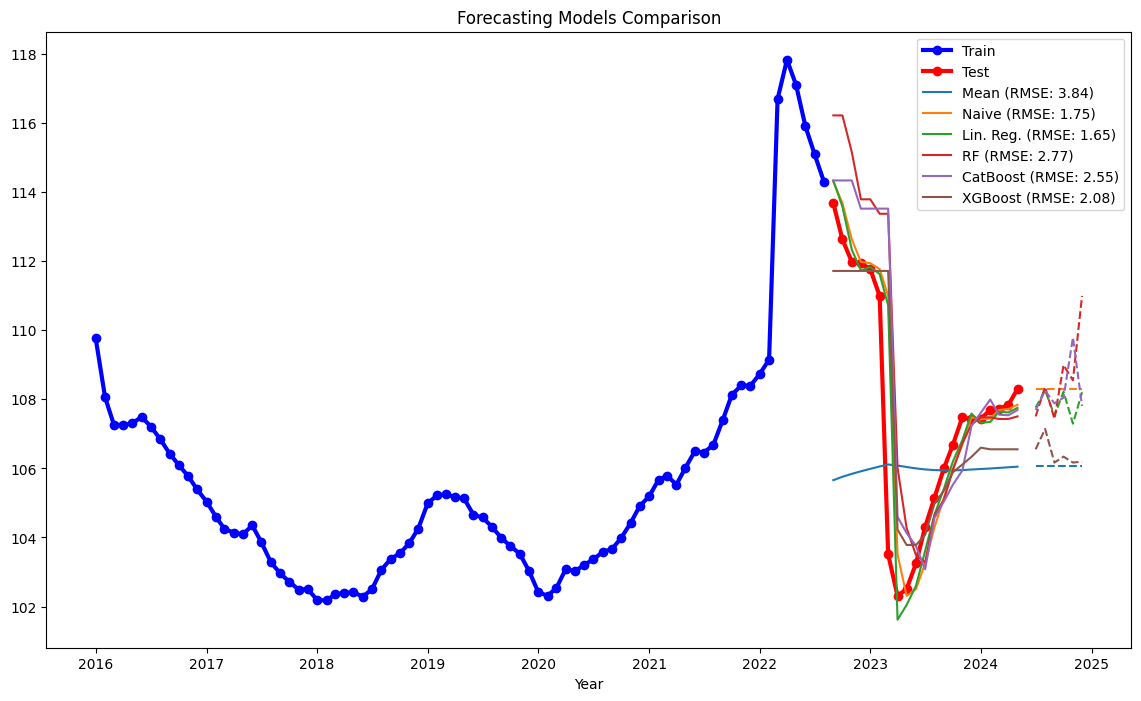

In [426]:
# List of models to evaluate
models = [
    ('Mean', mean_forecast),
    ('Naive', naive_forecast),
    ('Lin. Reg.', linear_regression_forecast),
    ('RF', random_forest_forecast),
    ('CatBoost', catboost_forecast),
    ('XGBoost', xgboost_forecast)
]

# Evaluate all models and plot results
plt.figure(figsize=(14, 8))
plt.plot(train.index, y_train, label='Train', linewidth = 3, color = 'blue', marker = 'o')
plt.plot(test.index, y_test, label='Test', linewidth = 3, color = 'red', marker = 'o')

# Store plot handles and colors for future use
plot_handles = {}

for name, model in models:
    predictions, rmse = evaluate_model(name, X_train, y_train, X_test, y_test, model)
    line, = plt.plot(test.index, predictions, label=f'{name} (RMSE: {rmse:.2f})')
    plot_handles[name] = line.get_color()  # Store the color of the current model's line
    
    # Make a 6-month forecast
    future_dates = pd.date_range(start=test.index[-1], periods=7, freq='M')[1:]
    future_predictions = make_6_month_forecast(model, X_full, y_full)
    plt.plot(future_dates, future_predictions, linestyle='--', color=plot_handles[name])

plt.legend()
plt.title('Forecasting Models Comparison')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xlabel('Year') 

plt.show()

In [205]:
def plot_models(models, X_train, y_train, X_test, y_test, X_full, y_full, file_path = None):
    '''
    Function to visualize models' performance on out-of-sample test data. Also plots future (6M ahead predictions) and saves matplotlib plot as a picture.
    '''
    plt.figure(figsize=(14, 8))
    plt.plot(y_train.index, y_train, label = 'Train', linewidth = 3, color = 'blue', marker = 'o')
    plt.plot(y_test.index, y_test, label = 'Test', linewidth = 3, color = 'red', marker = 'o')

    plot_handles = {}

    for name, model in models:
        predictions, rmse = evaluate_model(name, X_train, y_train, X_test, y_test, model)
        line, = plt.plot(test.index, predictions, label=f'{name} (RMSE: {rmse:.2f})')
        plot_handles[name] = line.get_color()

        future_dates = pd.date_range(start = y_test.index[-1], periods = 7, freq = 'M')[1:]
        future_predictions = make_6_month_forecast(model, X_full, y_full)
        plt.plot(future_dates, future_predictions, linestyle = '--', color = plot_handles[name])

    plt.legend()
    plt.title('Forecasting Models Comparison')
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xlabel('Year')
    plt.tight_layout()

    if file_path:
        try:
            dir_path = os.path.dirname(file_path)
            os.makedirs(dir_path, exist_ok = True)
            plt.savefig(file_path)
        except Exception as e:
            raise Exception
        
    
    plt.show()


Mean RMSE: 3.836
Naive RMSE: 1.752
Lin. Reg. RMSE: 1.878
RF RMSE: 3.711
CatBoost RMSE: 3.451
XGBoost RMSE: 2.073


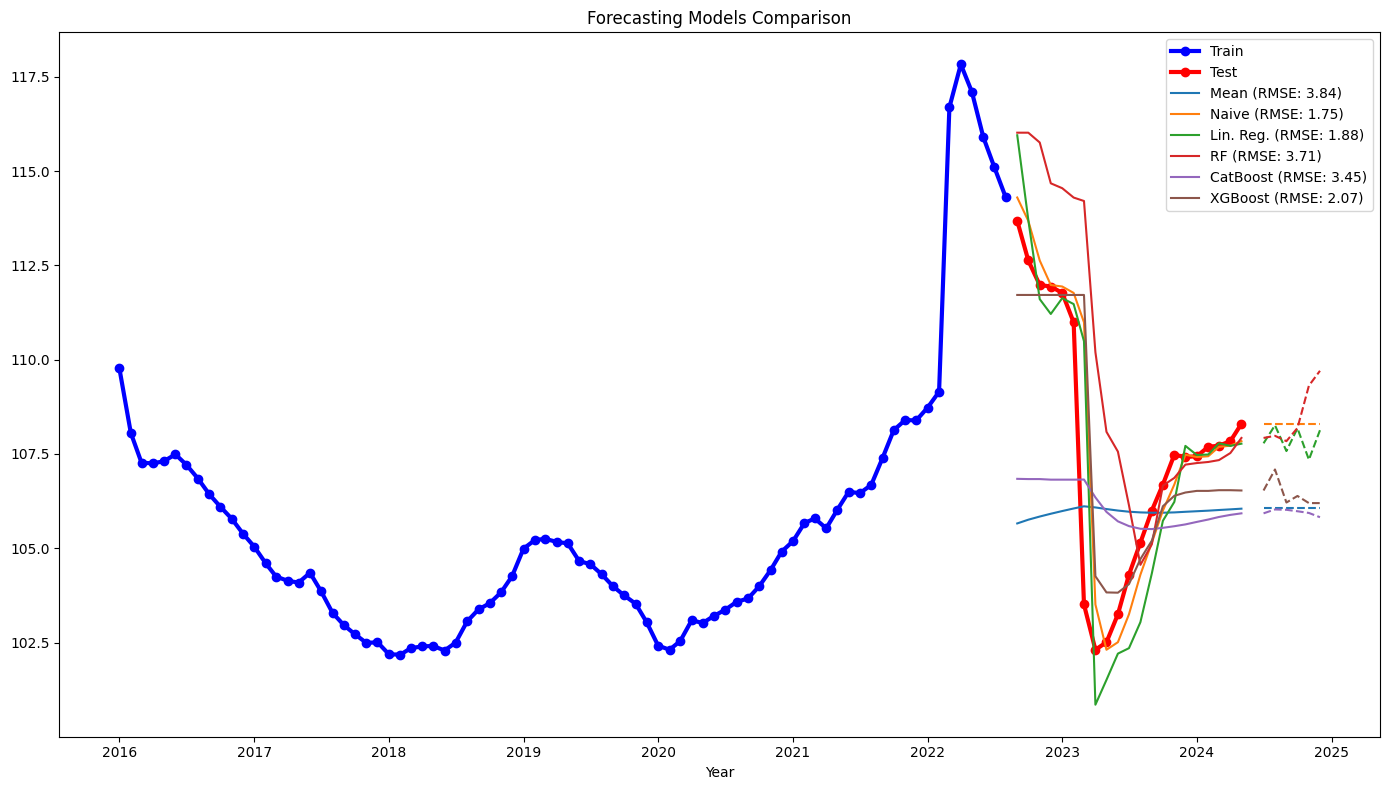

In [268]:
plot_models(models, X_train, y_train, X_test, y_test, X_full, y_full, file_path = os.path.join(os.getcwd(), "plot.png"))